# Causal Relationship Discovery

### Import and Settings

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graphviz as gv
import seaborn as sns
import time
import math
import sys
from scipy import stats

from models.lingam_master import lingam

from models.tigramite_master.tigramite.pcmci import PCMCI
from models.tigramite_master.tigramite.independence_tests.parcorr import ParCorr
from models.tigramite_master.tigramite import data_processing as pp
# from models.tigramite_master.tigramite.plotting import plot_graph

# from statsmodels.tsa.vector_ar.vecm import VECM

print([np.__version__, pd.__version__, gv.__version__, lingam.__version__])
np.set_printoptions(precision=3, suppress=True)

['1.24.4', '2.0.3', '0.20.3', '1.9.0']


### Data Preprocessing

In [133]:
def preprocess_data(data, columns, log_vars=None, percent_vars=None):
    """
    Preprocess the data by applying log transformation and percentage conversion.
    
    :param data: pandas DataFrame
    :param log_columns: list of column names to apply log transformation
    :param percentage_columns: list of column names to convert to percentages
    :return: preprocessed pandas DataFrame
    """
    if log_vars is None:
        log_vars = []
    if percent_vars is None:
        percent_vars = []

    # Convert column names to indices
    log_indices = [columns.index(var) for var in log_vars if var in columns]
    percent_indices = [columns.index(var) for var in percent_vars if var in columns]

    processed_data = data.copy()

    # Apply log transformation
    for idx in log_indices:
        processed_data[:, idx] = np.log(processed_data[:, idx])
    
    # Convert to percentages
    for idx in percent_indices:
        if abs(processed_data[:, idx].mean()) < 1:
            processed_data[:, idx] *= 100

    return np.round(processed_data, 3)

### Causal Discovery Algorithms

#### PCMCI

In [152]:
def run_pcmci(data, columns, alpha=0.05, tau_max=1):
    """
    Run PCMCI on the given data.
    
    :param data: pandas DataFrame
    :param alpha: significance level (default: 0.05)
    :param tau_max: maximum time lag to test (default: 5)
    :return: PCMCI results
    """
    dataframe = pp.DataFrame(data, 
                             datatime=np.arange(len(data)), 
                             var_names=columns)
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=1)
    results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=alpha)
    
    return results


def val_matrix_to_adjacency_matrices(val_matrix, p_matrix, alpha=0.05):
    """
    Convert PCMCI val_matrix to adjacency_matrices format.
    
    Parameters:
    val_matrix (np.array): The val_matrix from PCMCI results
    p_matrix (np.array): The p_matrix from PCMCI results
    alpha (float): Significance level for p-values (default: 0.05)
    
    Returns:
    list: A list of adjacency matrices (same as the VAR-LiNGAM format)
    """
    
    # Get the dimensions
    n_vars, _, n_lags = val_matrix.shape
    
    # Initialize the list of adjacency matrices
    adjacency_matrices = []
    
    # For each lag (including contemporaneous effects)
    for lag in range(n_lags):
        # Create a mask for significant relationships
        significant_mask = (p_matrix[:,:,lag] < alpha)
        
        # Get the values for this lag and apply the mask
        adj_matrix = np.where(significant_mask, val_matrix[:,:,lag], 0)# Get the values for this lag and apply the mask
        
        # Append to the list
        adjacency_matrices.append(adj_matrix)
    
    return adjacency_matrices

#### VAR-LiNGAM

In [148]:
def run_varlingam(data, lags=5):
    """
    Run VAR-LiNGAM on the given data.
    
    :param data: pandas DataFrame
    :param lags: number of lags to include (default: 5)
    :return: VARLiNGAM results
    """
    model = lingam.VARLiNGAM(lags=lags, prune=True)
    results = model.fit(data)
    return results


def plot_causal_graph_varlingam(
    adjacency_matrices,
    node_labels=None,
    title="Causal Graph - VAR-LiNGAM",
    lower_limit=0.01,
    ignore_shape=False
):
    num_layers = len(adjacency_matrices)
    num_nodes_per_layer = adjacency_matrices[0].shape[0]
    
    # Automatically generate full labels
    labels = []
    for t in range(num_layers):
        for node in node_labels:
            if t == 0:
                labels.append(f"{node}(t)")
            else:
                labels.append(f"{node}(t-{t})")
    
    d = gv.Digraph(engine="fdp")
    d.attr(rankdir="LR", splines="curved")
    d.attr(label=title, labelloc="t", labeljust="c")
    
    # Create nodes with specific positions
    for layer in range(num_layers):
        for node in range(num_nodes_per_layer):
            node_name = labels[layer * num_nodes_per_layer + node] if labels else f"x{node}(t-{num_layers-layer-1})"
            x_pos = (num_layers - layer - 1) * 5
            y_pos = (num_nodes_per_layer - node - 1) * 2
            d.node(node_name, pos=f"{x_pos},{y_pos}!")
    
    base_colors = ["red", "green", "blue"]  # Define colors for layers
    
    # Add edges
    for layer in range(num_layers):
        B = adjacency_matrices[layer]
        idx = np.abs(B) > lower_limit
        dirs = np.where(idx)
        color = base_colors[layer % len(base_colors)]
        for to, from_, coef in zip(dirs[0], dirs[1], B[idx]):
            from_name = labels[layer * num_nodes_per_layer + from_] if labels else f"x{from_}(t-{num_layers-layer-1})"
            to_name = labels[to] if layer > 0 else labels[to]
            d.edge(from_name, to_name, 
                   label=f"<<b>{coef:.2f}</b>>",  # Bold label with coefficient value
                   color=color,  # Edge color based on layer
                   fontsize="10",
                   decorate="true",  # Makes the label follow the line
                   labelloc="t",  # Places the label above the line
                   penwidth="1",
                   arrowsize="0.5")

    display(d)
    return d


def plot_heatmap_varlingam(adjacency_matrices, columns):
    num_matrices = len(adjacency_matrices)
    
    # set figure layout
    if num_matrices <= 3:
        nrows, ncols = 1, num_matrices
    else:
        nrows = math.ceil(num_matrices / 3)
        ncols = min(num_matrices, 3)
    
    # set figure size
    fig_width = 5 * ncols
    fig_height = 4 * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    
    # If there is only one subplot, convert axes to a 2D array for uniform processing
    if num_matrices == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    
    # set y labels
    y_labels = [f"{col}(t)" for col in columns]
    
    for i, matrix in enumerate(adjacency_matrices):
        row = i // ncols
        col = i % ncols
        ax = axes[row, col]
        
        # set x labels
        if i == 0:
            x_labels = y_labels
        else:
            x_labels = [f"{col}(t-{i})" for col in columns]
        
        sns.heatmap(matrix, ax=ax, cmap='YlOrRd', annot=True, fmt='.2f', 
                    xticklabels=x_labels, yticklabels=y_labels)
        ax.set_title(f"Heatmap with Lag {i}")

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # remove extra subplots
    for i in range(num_matrices, nrows * ncols):
        row = i // ncols
        col = i % ncols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

### Running the code - get causal graph and correlation matrices

dataset shape: (1000, 5)

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable x0 has 3 link(s):
        (x0 -1): max_pval = 0.00000, |min_val| =  0.487
        (x3 -1): max_pval = 0.00000, |min_val| =  0.288
        (x1 -1): max_pval = 0.01539, |min_val| =  0.077

    Variable x1 has 3 link(s):
        (x1 -1): max_pval = 0.00000, |min_val| =  0.380
        (x3 -1): max_pval = 0.00000, |min_val| =  0.291
        (x0 -1): max_pval = 0.00000, |min_val| =  0.154

    Variable x2 has 3 link(s):
        (x2 -1): max_pval = 0.00000, |min_val| =  0.468
        (x1 -1): max_pval = 0.00000, |min_val| =  0.163
        (x3 -1): max_pval = 0.00306, |min_val| =  0.094

    Variable x3 has 3 link(s):
        (x3 -1): max_pval = 0.00000, |min_val| =  0.474
        (x1 -1): max_pval = 0.00006, |min_val| =  0.12

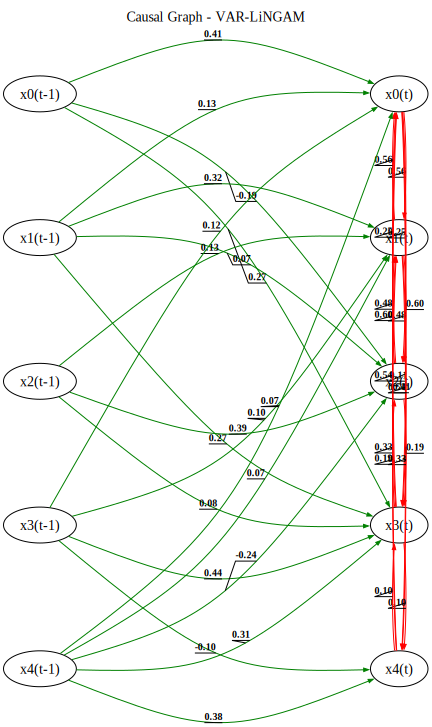

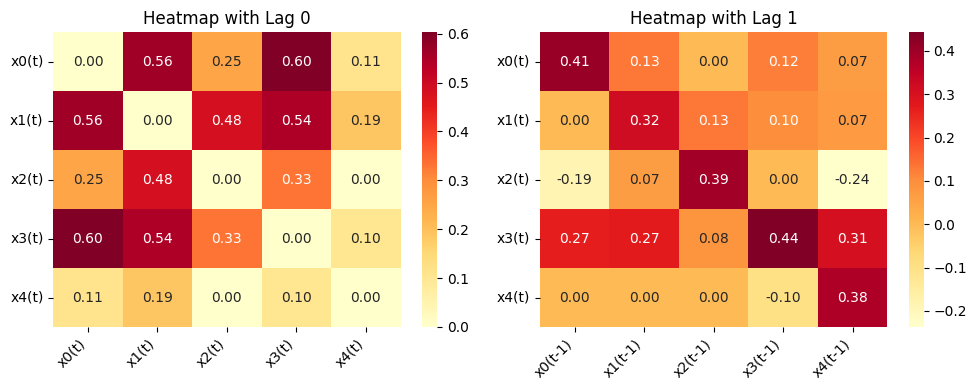

Execution time: 0.17722487449645996 seconds


In [164]:
### Load data ###
data = pd.read_csv('data/sample2/test_data.csv')
# data = pd.read_csv('data/dairy/dairy_preprocessed.csv')
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis = 1).values
    columns.remove('Date')
else:
    data = data.values
print("dataset shape:", data.shape)


### Data preprocessing ###
log_vars = None
percent_vars = None
# log_vars = ['C', 'I', 'Y', 'P']     # Variables to log-transform
# percent_vars = ['U', 'R']         # Variables to convert to percentages

data = preprocess_data(data, columns, log_vars=log_vars, percent_vars=percent_vars)
# np.savetxt('preprocessed_data.csv', data, delimiter=',')


### Run causal discovery method ###
method = "pcmci"  # 'pcmci' or 'varlingam'

# Run chosen method and plot results
start_time = time.time()
if method == 'pcmci':
    results = run_pcmci(data, columns)
    end_time = time.time()
    print(results["val_matrix"])
    adj = val_matrix_to_adjacency_matrices(results["val_matrix"], results["p_matrix"], alpha=0.05)
    print("Adjacency matrices: ", adj)
    plot_causal_graph_varlingam(adj, node_labels=columns)
    plot_heatmap_varlingam(adj, columns)
elif method == 'varlingam':
    results = run_varlingam(data)
    end_time = time.time()
    print("Adjacency matrices: ", results.adjacency_matrices_)
    plot_causal_graph_varlingam(results.adjacency_matrices_, node_labels=columns)
    plot_heatmap_varlingam(results.adjacency_matrices_, columns)
else:
    print("Invalid method chosen")
    exit()

print(f"Execution time: {end_time - start_time} seconds")

### plot time series

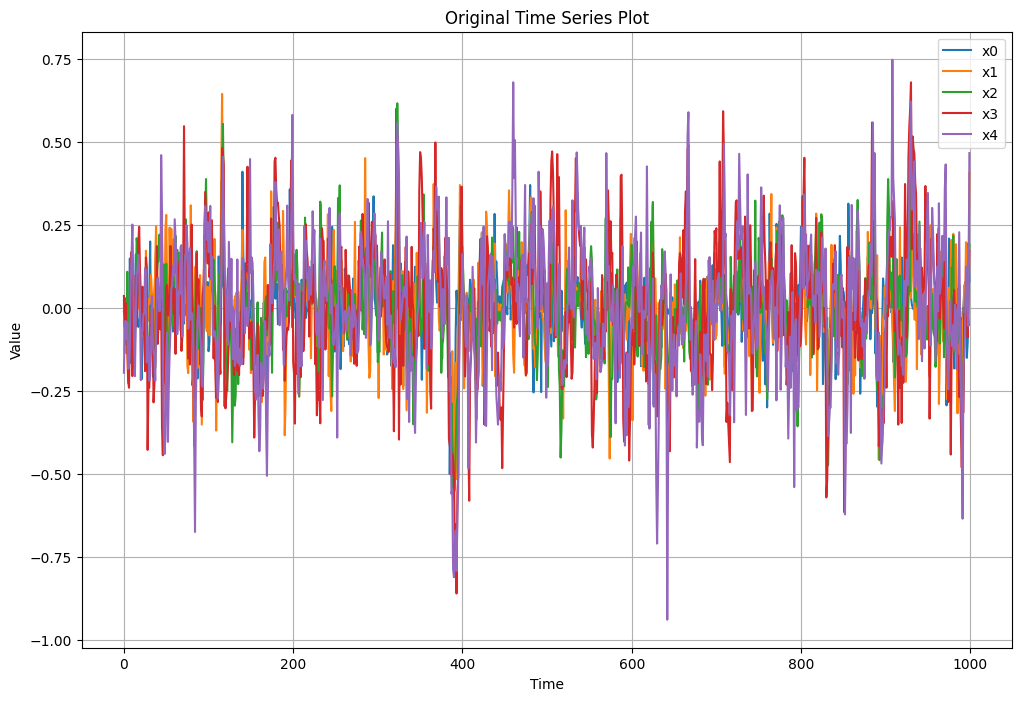

In [138]:
def plot_time_series(data, title="Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for i in range(data.shape[1]):
        plt.plot(data[:, i], label = columns[i])
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_time_series(data, title="Original Time Series Plot")

# Causal relation validation assessment
We compare the estimated causal structures with the correct pattern using sign, size, and conjugate similarity tests.

In [52]:
from sklearn.metrics import f1_score

def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

def structural_hamming_distance(A, B):
    return np.sum(np.abs(np.sign(A) - np.sign(B)))

def calculate_f1(A, B):
    true = (np.abs(A) > 1e-6).flatten()
    pred = (np.abs(B) > 1e-6).flatten()
    return f1_score(true, pred)

def calculate_weighted_f1(A, B, thresholds=[0.1, 0.5]):
    def categorize(X):
        categories = np.zeros_like(X)
        for i, threshold in enumerate(thresholds, 1):
            categories[np.abs(X) > threshold] = i
        return categories.flatten()

    true_cat = categorize(A)
    pred_cat = categorize(B)
    
    return f1_score(true_cat, pred_cat, average='weighted')

def compare_matrices(true_matrices, est_matrices):
    results = {}
    
    # Combine all matrices into single matrices for true and estimated
    true_combined = np.hstack(true_matrices)
    est_combined = np.hstack(est_matrices[:len(true_matrices)])  # Use only up to the number of true matrices
    print("True combined: \n", true_combined)
    print("Est combined: \n", est_combined)
    
    # Check if true and estimated matrices have the same shape
    if len(true_combined) !=  len(est_combined):
        print("Numbers of Variable Mismatch. True and estimated matrices have different shapes")
        sys.exit(1)
    
    
    # Calculate metrics for the combined matrices
    results['fro'] = frobenius_norm(true_combined, est_combined) # Element-wise comparison
    results['shd'] = structural_hamming_distance(true_combined, est_combined) # Edge-wise comparison
    results['f1'] = calculate_f1(true_combined, est_combined)
    results['weighted_f1'] = calculate_weighted_f1(true_combined, est_combined) # Weighted by the strength of edges
    
    # Record the number of lags
    results['true_lags'] = len(true_matrices)
    results['est_lags'] = len(est_matrices)
    results['extra_lags'] = max(0, len(est_matrices) - len(true_matrices))
    results['missing_lags'] = max(0, len(true_matrices) - len(est_matrices))
    
    # Record the number of true edges
    results['num_true_edges'] = np.sum(np.abs(np.sign(true_combined)))
    
    return results

def interpret_results(results):
    interpretations = {}
    
    # Interpret Frobenius norm
    fro = results['fro']
    if fro < 0.1:
        interpretations['Frobenius Norm'] = f"Excellent: {fro:.3f}. Very close match between true and estimated matrices."
    elif fro < 0.5:
        interpretations['Frobenius Norm'] = f"Good: {fro:.3f}. Reasonable match between true and estimated matrices."
    elif fro < 1.0:
        interpretations['Frobenius Norm'] = f"Fair: {fro:.3f}. Some discrepancies between true and estimated matrices."
    else:
        interpretations['Frobenius Norm'] = f"Poor: {fro:.3f}. Large discrepancies between true and estimated matrices."
    
    # Interpret Structural Hamming Distance 
    shd = results['shd']
    total_elements = np.prod(results['num_true_edges'])
    shd_ratio = shd / total_elements
    print("SHD: ", shd)
    print("Total elements: ", total_elements)
    print("SHD ratio: ", shd_ratio)
    if shd_ratio < 0.1:
        interpretations['Structural Hamming Distance'] = f"Excellent: {shd} ({shd_ratio:.2%}). Very few structural differences."
    elif shd_ratio < 0.2:
        interpretations['Structural Hamming Distance'] = f"Good: {shd} ({shd_ratio:.2%}). Some structural differences."
    elif shd_ratio < 0.5:
        interpretations['Structural Hamming Distance'] = f"Fair: {shd} ({shd_ratio:.2%}). Significant structural differences."
    else:
        interpretations['Structural Hamming Distance'] = f"Poor: {shd} ({shd_ratio:.2%}). Many structural differences."
    
    # Interpret F1 Score
    f1 = results['f1']
    if f1 > 0.9:
        interpretations['f1'] = f"Excellent: {f1:.3f}. Very high accuracy in identifying causal relationships."
    elif f1 > 0.7:
        interpretations['f1'] = f"Good: {f1:.3f}. Good accuracy in identifying causal relationships."
    elif f1 > 0.5:
        interpretations['f1'] = f"Fair: {f1:.3f}. Moderate accuracy in identifying causal relationships."
    else:
        interpretations['f1'] = f"Poor: {f1:.3f}. Low accuracy in identifying causal relationships."
    
    # Interpret Weighted F1 Score
    # Interpret F1 Score
    weighted_f1 = results['weighted_f1']
    if f1 > 0.9:
        interpretations['weighted_f1'] = f"Excellent: {f1:.3f}. Very high accuracy in identifying causal relationships."
    elif f1 > 0.7:
        interpretations['weighted_f1'] = f"Good: {f1:.3f}. Good accuracy in identifying causal relationships."
    elif f1 > 0.5:
        interpretations['weighted_f1'] = f"Fair: {f1:.3f}. Moderate accuracy in identifying causal relationships."
    else:
        interpretations['weighted_f1'] = f"Poor: {f1:.3f}. Low accuracy in identifying causal relationships."
    
    # Interpret lag estimation
    if results['extra_lags'] == 0 and results['missing_lags'] == 0:
        interpretations['lags'] = f"Perfect: Correctly estimated {results['true_lags']} lags."
    elif results['extra_lags'] > 0:
        interpretations['lags'] = f"Overestimation: Estimated {results['est_lags']} lags, with {results['extra_lags']} extra lags."
    else:
        interpretations['lags'] = f"Underestimation: Estimated {results['est_lags']} lags, lack {results['missing_lags']} lags."
    
    return interpretations

### Running the code - get validation results

In [86]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.stattools import coint
import itertools
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

def adf_test(timeseries):
    result = adfuller(timeseries)
    return result[0], result[1], result[4]

def johansen_test(data, det_order=0):
    return coint_johansen(data, det_order=det_order, k_ar_diff=1)

def pairwise_cointegration(data):
    n = data.shape[1]
    pairs = []
    for i, j in itertools.combinations(range(n), 2):
        _, pvalue, _ = coint(data[:, i], data[:, j])
        if pvalue < 0.05:
            pairs.append((i, j))
    return pairs

def select_best_vecm(data, max_vars=5, johansen_result=None, cointegrated_pairs=None):
    n = data.shape[1]
    best_aic = np.inf
    best_combo = None
    
    if johansen_result is not None:
        cointegration_rank = sum(johansen_result.lr1 > johansen_result.cvt[:, 1])
    else:
        cointegration_rank = 1
    
    priority_vars = set([var for pair in (cointegrated_pairs or []) for var in pair])
    
    for r in range(max(2, cointegration_rank), min(max_vars, n) + 1):
        for combo in itertools.combinations(range(n), r):
            if priority_vars and not set(combo).intersection(priority_vars):
                continue
            
            vecm_data = data[:, combo]
            model = VECM(vecm_data, k_ar_diff=1, deterministic="ci")
            try:
                results = model.fit()
                aic = 2 * len(results.params) - 2 * results.llf
                if aic < best_aic:
                    best_aic = aic
                    best_combo = combo
            except:
                continue
    
    return best_combo

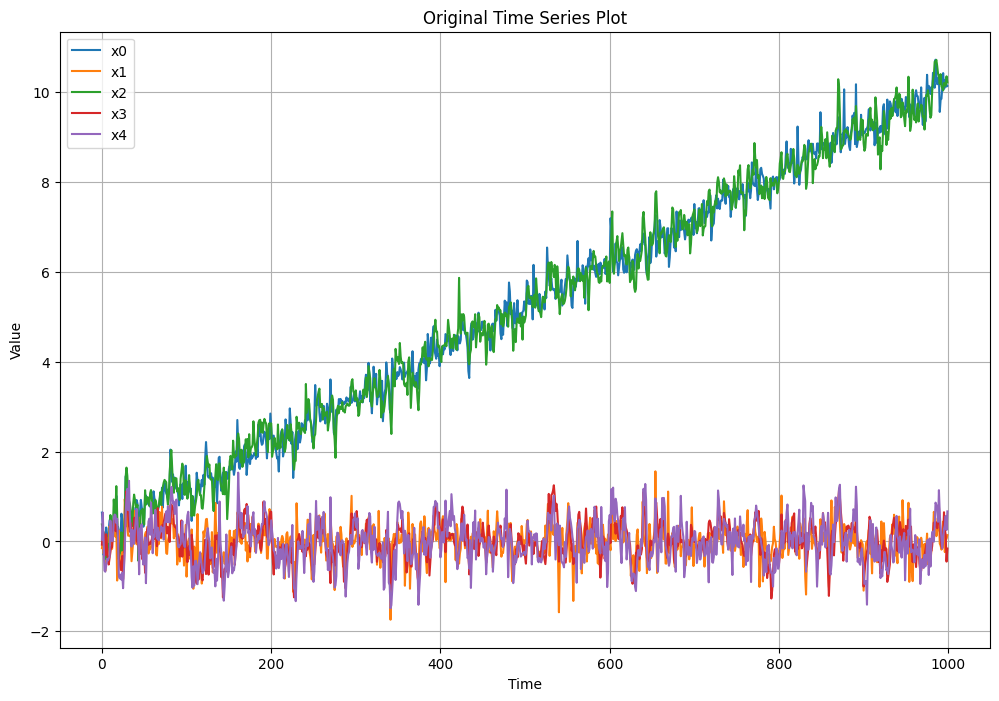

dataset shape: (1000, 5)
True combined: 
 [[0.  0.  0.  0.  0.  0.4 0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.1 0.3 0.  0.  0. ]
 [0.3 0.2 0.  0.  0.  0.  0.2 0.5 0.  0. ]
 [0.  0.4 0.1 0.  0.  0.  0.  0.1 0.6 0. ]
 [0.2 0.  0.3 0.1 0.  0.1 0.  0.  0.2 0.4]]
Est combined: 
 [[ 0.     0.     0.     0.     0.     0.47   0.     0.068  0.    -0.121]
 [ 0.476  0.     0.     0.     0.     0.     0.301  0.     0.     0.076]
 [ 0.352  0.209  0.     0.     0.     0.     0.202  0.51   0.    -0.036]
 [-0.069  0.45   0.081  0.     0.     0.     0.     0.086  0.635  0.   ]
 [ 0.176  0.     0.206  0.262  0.     0.     0.     0.     0.171  0.454]]
SHD:  7.0
Total elements:  18.0
SHD ratio:  0.3888888888888889

Result Interpretations:
[Frobenius Norm] Good: 0.321. Reasonable match between true and estimated matrices.
[Structural Hamming Distance] Fair: 7.0 (38.89%). Significant structural differences.
[f1] Good: 0.821. Good accuracy in identifying causal relationships.
[weighted_f1] Good: 0.821. Good a

In [95]:
# Load true matrices
# B0 = np.array([
#     [0.000, 0.000, 0.188],
#     [0.901, 0.000, 0.000],
#     [0.000, 0.000, 0.000]
# ])

# B1 = np.array([
#     [0.979, 0.000, -0.183],
#     [-0.857, 0.949, 0.000],
#     [0.000, 0.000, 0.992]
# ])

B0 = np.array([
    [0, 0, 0, 0, 0],
    [0.5, 0, 0, 0, 0],
    [0.3, 0.2, 0, 0, 0],
    [0, 0.4, 0.1, 0, 0],
    [0.2, 0, 0.3, 0.1, 0]
])

B1 = np.array([
    [0.4, 0, 0, 0, 0],
    [0.1, 0.3, 0, 0, 0],
    [0, 0.2, 0.5, 0, 0],
    [0, 0, 0.1, 0.6, 0],
    [0.1, 0, 0, 0.2, 0.4]
])


true_matrices = [B0, B1]

### Load estimated matrices ###
data = pd.read_csv('data/sample2/test_data_with_trends.csv')
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis = 1).values
    columns.remove('Date')
else:
    data = data.values

plot_time_series(data, title="Original Time Series Plot")
print("dataset shape:", data.shape)

###########
###########

# print("數據集形狀:", data.shape)
# plot_time_series(data, title="原始時間序列圖")

# print("\n單位根檢驗 (ADF測試)結果:")
# for i in range(data.shape[1]):
#     adf_statistic, p_value, _ = adf_test(data[:, i])
#     print(f"變量 {i}: ADF統計量 = {adf_statistic:.4f}, p值 = {p_value:.4f}")

# johansen_result = johansen_test(data)
# print("\nJohansen協整檢驗結果:")
# print("跡統計量:", johansen_result.lr1)
# print("臨界值 (90%, 95%, 99%):", johansen_result.cvt)

# cointegrated_pairs = pairwise_cointegration(data)
# print("\n成對協整檢驗結果:")
# print("協整對:", cointegrated_pairs)

# best_combo = select_best_vecm(data, johansen_result=johansen_result, cointegrated_pairs=cointegrated_pairs)
# print("\n最佳VECM變量組合:", best_combo)

# vecm_vars = data[:, best_combo]
# vecm_model = VECM(vecm_vars, k_ar_diff=1, deterministic="ci")
# vecm_results = vecm_model.fit()

# print("\nVECM模型係數 (alpha):")
# print(vecm_results.alpha)


# vecm_residuals = vecm_results.resid
# other_vars_indices = [i for i in range(data.shape[1]) if i not in best_combo]
# other_vars = data[:, other_vars_indices]
# combined_data = np.column_stack((vecm_residuals, other_vars))

# print("\n合併後的數據集形狀:", combined_data.shape)
# plot_time_series(combined_data, title="VECM處理後的時間序列圖")




###########
###########

# idx = [0, 2]
# for i in idx:
#     data[1:, i] = np.diff(data[:, i])

# data = data[1:, :]

# plot_time_series(data, title="lbablalaba Time Series Plot")
# print("dataset shape:", data.shape)

causal_results = run_varlingam(data)

### Compare and interpret results ###
comparison_results = compare_matrices(true_matrices, causal_results.adjacency_matrices_)
interpretations = interpret_results(comparison_results)

print("\nResult Interpretations:")
for key, value in interpretations.items():
    print(f"[{key}] {value}")